Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

 # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
          shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)

  # Variables.
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * tf.nn.l2_loss(weights)

  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: .003}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 22.294689
Minibatch accuracy: 17.2%
Validation accuracy: 17.0%
Minibatch loss at step 500: 2.289596
Minibatch accuracy: 84.4%
Validation accuracy: 78.0%
Minibatch loss at step 1000: 1.087309
Minibatch accuracy: 78.9%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 0.565089
Minibatch accuracy: 84.4%
Validation accuracy: 81.5%
Minibatch loss at step 2000: 0.602535
Minibatch accuracy: 88.3%
Validation accuracy: 81.6%
Minibatch loss at step 2500: 0.723652
Minibatch accuracy: 80.5%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.718541
Minibatch accuracy: 84.4%
Validation accuracy: 81.8%
Test accuracy: 89.1%


In [7]:
betas = [pow(10, i) for i in np.arange(-5, 0, 0.1)]

In [8]:
num_steps = 3001
accuracies = []
for beta_test in betas:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: beta_test}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracies.append(accuracy(test_prediction.eval(),test_labels))

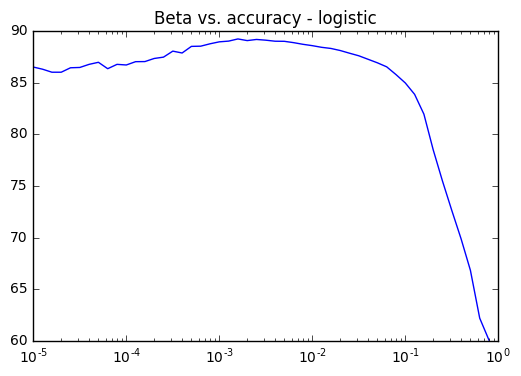

In [9]:
import matplotlib.pyplot as plt
plt.semilogx(betas, accuracies)
plt.title('Beta vs. accuracy - logistic')
plt.show()

In [59]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_nn = tf.placeholder(tf.float32)
  
  # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_nn* (tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2))
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [60]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_nn: .001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 681.881409
Minibatch accuracy: 10.9%
Validation accuracy: 28.5%
Minibatch loss at step 500: 198.831894
Minibatch accuracy: 78.9%
Validation accuracy: 78.6%
Minibatch loss at step 1000: 116.618217
Minibatch accuracy: 78.1%
Validation accuracy: 80.9%
Minibatch loss at step 1500: 68.321312
Minibatch accuracy: 88.3%
Validation accuracy: 83.0%
Minibatch loss at step 2000: 41.195415
Minibatch accuracy: 89.1%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 25.080158
Minibatch accuracy: 86.7%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 15.485303
Minibatch accuracy: 82.8%
Validation accuracy: 86.5%
Test accuracy: 93.0%


In [16]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_nn = tf.placeholder(tf.float32)
  
  # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_nn* (tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2))
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [24]:
betas = [pow(10, i) for i in np.arange(-5, 0, 0.5)]
accuracies = []
num_steps = 3001

for beta_test in betas:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_nn: beta_test}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracies.append(accuracy(test_prediction.eval(),test_labels))

KeyboardInterrupt: 

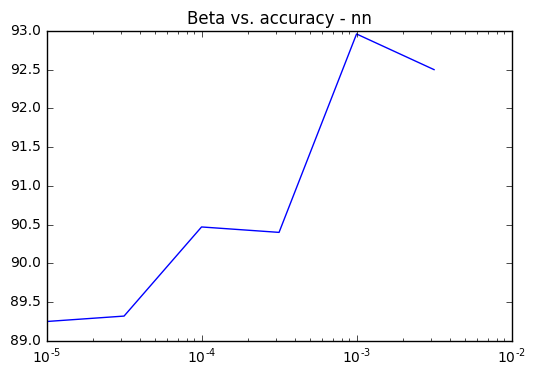

In [25]:
import matplotlib.pyplot as plt
plt.semilogx(betas[:len(accuracies)], accuracies)
plt.title('Beta vs. accuracy - nn')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [37]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

  
  # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [38]:
num_steps = 300
num_batches = 6
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 310.360382
Minibatch accuracy: 19.5%
Validation accuracy: 28.4%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Minibatch loss at step 200: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.2%
Test accuracy: 70.0%


overfits the minibatch, but doesn't do well on validation or testing data since there is no regularization and the number of training examples is small.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [46]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_nn = tf.placeholder(tf.float32)
  
  # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    dropout = tf.nn.dropout(layer1,.5)
    logits = tf.matmul(dropout, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))  + beta_nn* (tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2))
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [48]:
num_steps = 301
num_batches = 6
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_nn: .001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 767.227295
Minibatch accuracy: 7.8%
Validation accuracy: 30.9%
Minibatch loss at step 100: 285.337250
Minibatch accuracy: 100.0%
Validation accuracy: 69.1%
Minibatch loss at step 200: 259.943848
Minibatch accuracy: 98.4%
Validation accuracy: 70.4%
Minibatch loss at step 300: 233.708878
Minibatch accuracy: 100.0%
Validation accuracy: 70.9%
Test accuracy: 78.2%


Does better with dropout, also added regularization for a slight improvement

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [176]:
batch_size = 128
hidden_nodes_1 = 2**10
hidden_nodes_2 = 2**8
hidden_nodes_3 = 2**7


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_nn = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.
  
  # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes_1],stddev=np.sqrt(1.0 / (50*image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([hidden_nodes_1]))
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes_1, hidden_nodes_2],stddev=np.sqrt(1.0 / hidden_nodes_1)))
    biases2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    weights3 = tf.Variable(
        tf.truncated_normal([hidden_nodes_2, hidden_nodes_3],stddev=np.sqrt(1.0 / hidden_nodes_2)))
    biases3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    weights4 = tf.Variable(
        tf.truncated_normal([hidden_nodes_3, num_labels],stddev=np.sqrt(4.0 / hidden_nodes_3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(layer1, 0.5)
    layer2 = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    #drop2 = tf.nn.dropout(layer2, 0.5)
    layer3 = tf.nn.relu(tf.matmul(layer2, weights3) + biases3)
    
    logits = tf.matmul(layer3, weights4) + biases4
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_nn* (tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights2)+tf.nn.l2_loss(weights3)+tf.nn.l2_loss(weights4))
  
  # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000,.65,staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid, weights2) + biases2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(
        tf.matmul(layer3_valid, weights4) + biases4)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(layer3_test, weights4) + biases4)

In [177]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_nn: .0001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.323068
Minibatch accuracy: 7.8%
Validation accuracy: 23.4%
Minibatch loss at step 1000: 0.586732
Minibatch accuracy: 83.6%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 0.381879
Minibatch accuracy: 90.6%
Validation accuracy: 86.8%
Minibatch loss at step 3000: 0.481350
Minibatch accuracy: 85.9%
Validation accuracy: 87.0%
Minibatch loss at step 4000: 0.451648
Minibatch accuracy: 87.5%
Validation accuracy: 87.8%
Minibatch loss at step 5000: 0.501731
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 6000: 0.571493
Minibatch accuracy: 84.4%
Validation accuracy: 88.7%
Minibatch loss at step 7000: 0.469047
Minibatch accuracy: 85.2%
Validation accuracy: 89.1%
Minibatch loss at step 8000: 0.668314
Minibatch accuracy: 79.7%
Validation accuracy: 89.2%
Minibatch loss at step 9000: 0.453589
Minibatch accuracy: 89.1%
Validation accuracy: 89.4%
Minibatch loss at step 10000: 0.369306
Minibatch accuracy: 89.1%
Validation accura

highest score without dropout is 96.3%. with dropout1 I got 96.4. added dropout2: 95.8